In [23]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
import supervision as sv
from supervision.metrics.detection import MeanAveragePrecision, ConfusionMatrix
from tqdm.auto import tqdm
import pandas as pd
import yaml
import seaborn as sns
from sklearn.model_selection import train_test_split
from pathlib import Path
import rasterio
import shutil
import glob

# Define the base directory (Jupyter Notebook's working directory)
base_dir = os.getcwd()

# Load YOLO model
best_model = YOLO('YOLOv8n.pt')

# Define paths
test_images_path = os.path.join(base_dir, "solar_panel_project/dataset/images/test")
test_labels_path = os.path.join(base_dir, "solar_panel_project/dataset/labels/test")

# Ensure the directories exist
if not os.path.exists(test_images_path):
    raise FileNotFoundError(f"Test images path not found: {test_images_path}")
if not os.path.exists(test_labels_path):
    raise FileNotFoundError(f"Test labels path not found: {test_labels_path}")

# Get all test images
test_image_files = glob.glob(os.path.join(test_images_path, "*.tif"))  # Adjust extension if needed

# Ensure there are enough samples to choose from
if len(test_image_files) < 4:
    raise ValueError(f"Not enough test images found in {test_images_path}")

# Select 4 random test images
random_test_samples = random.sample(test_image_files, 4)

# Create (image_file, label_file) pairs
random_test_samples = [
    (img_file, img_file.replace("images", "labels").replace(".tif", ".txt")) for img_file in random_test_samples
]

# Visualization function for TIFF files
def visualize_detection(image_path, label_path, model, conf_threshold=0.25, iou_threshold=0.45):
    """Loads an image and its YOLO annotations, runs inference, and visualizes predictions."""
    
    # Load TIFF image using rasterio
    with rasterio.open(image_path) as src:
        image_data = src.read()
        
        # Handle RGB/Band conversion
        if image_data.shape[0] >= 3:  
            image = np.transpose(image_data[:3], (1, 2, 0))  
            if image.max() > 255:
                image = (image / 65535 * 255).astype(np.uint8)
            elif image.max() <= 1:
                image = (image * 255).astype(np.uint8)
        else:  
            image = np.stack([image_data[0]] * 3, axis=2)  
            if image.max() > 255:
                image = (image / 65535 * 255).astype(np.uint8)
            elif image.max() <= 1:
                image = (image * 255).astype(np.uint8)
    
    h, w = image.shape[:2]
    
    # Run YOLO inference
    results = model(image_path, conf=conf_threshold, iou=iou_threshold)[0]
    
    # Parse ground truth boxes
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                class_id, x_center, y_center, width, height = map(float, parts)
                
                # Convert YOLO format to pixel coordinates
                x1 = int((x_center - width/2) * w)
                y1 = int((y_center - height/2) * h)
                x2 = int((x_center + width/2) * w)
                y2 = int((y_center + height/2) * h)
                
                gt_boxes.append((x1, y1, x2, y2, int(class_id)))
    
    # Visualization
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    
    # Draw ground truth boxes in green
    for x1, y1, x2, y2, _ in gt_boxes:
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='green', linewidth=2, label='Ground Truth'))
    
    # Draw predicted boxes in red
    for box in results.boxes.xyxy:
        x1, y1, x2, y2 = map(int, box)
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2, label='Prediction'))
    
    # Add legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.title(f'Solar Panel Detection - {os.path.basename(image_path)}')
    plt.axis('off')
    return plt


image 1/1 C:\Users\HP\Downloads\labels-20250212T103318Z-001\labels\solar_panel_project\dataset\images\test\solarpanels_native_3__x0_9853_y0_14052_dxdy_416.tif: 640x640 (no detections), 321.9ms
Speed: 17.4ms preprocess, 321.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


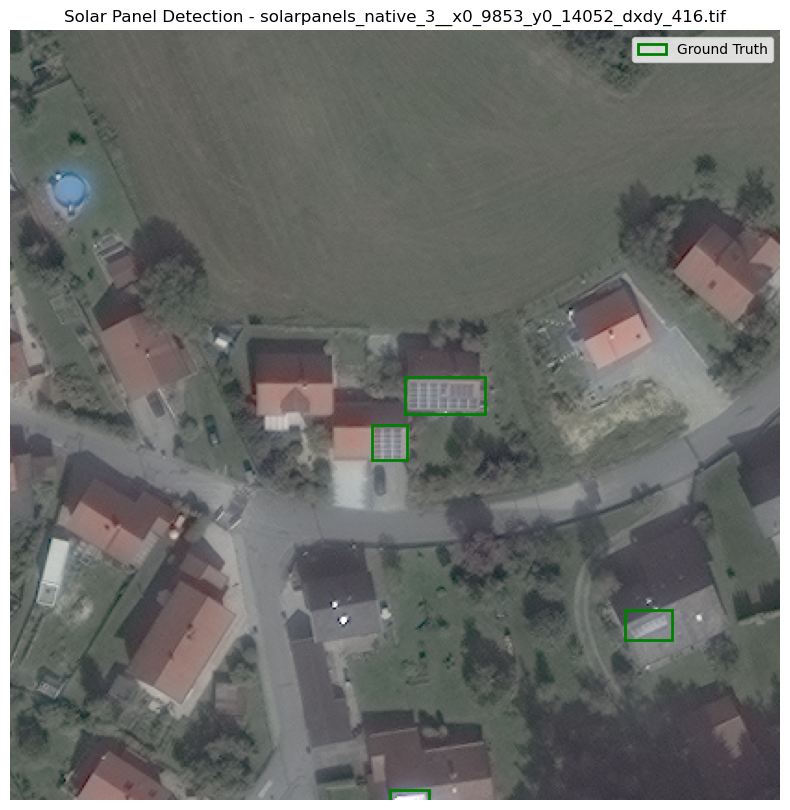


image 1/1 C:\Users\HP\Downloads\labels-20250212T103318Z-001\labels\solar_panel_project\dataset\images\test\solarpanels_native_1__x0_8028_y0_11500_dxdy_416.tif: 640x640 1 broccoli, 289.1ms
Speed: 15.0ms preprocess, 289.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


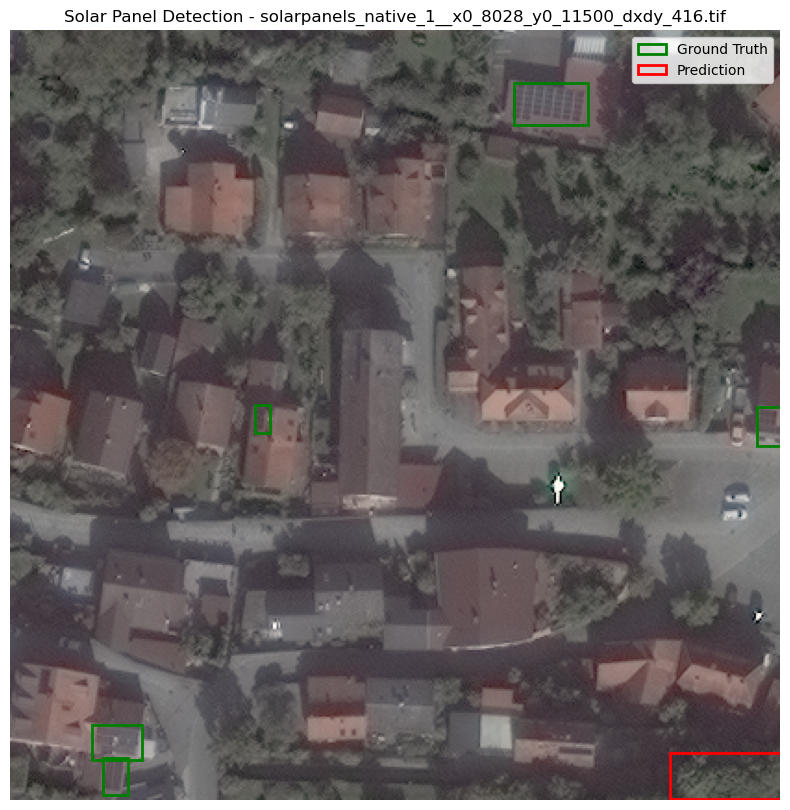


image 1/1 C:\Users\HP\Downloads\labels-20250212T103318Z-001\labels\solar_panel_project\dataset\images\test\solarpanels_native_1__x0_1380_y0_10215_dxdy_416.tif: 640x640 (no detections), 182.7ms
Speed: 8.9ms preprocess, 182.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


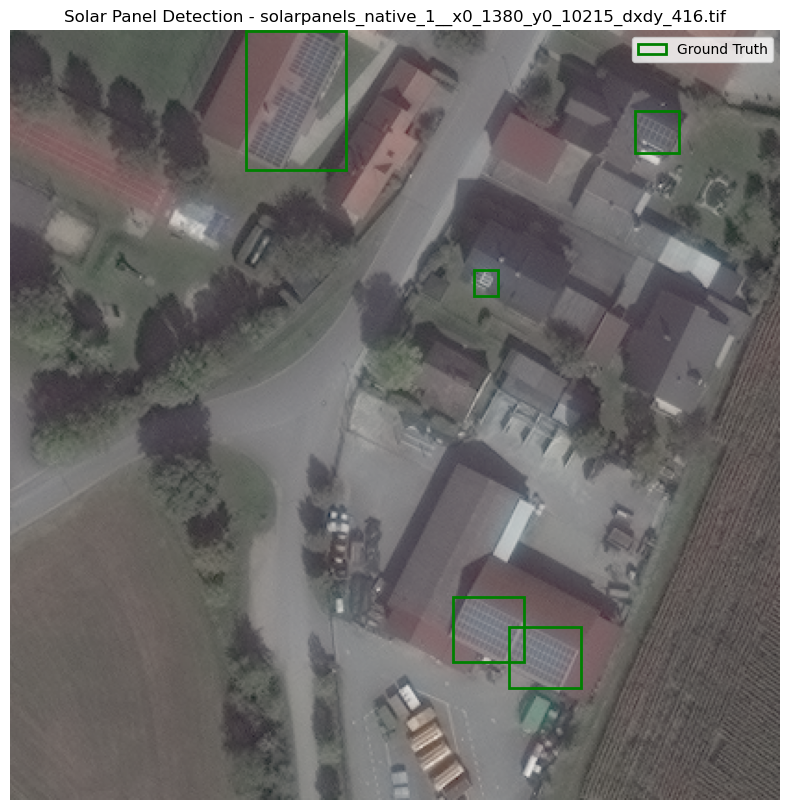


image 1/1 C:\Users\HP\Downloads\labels-20250212T103318Z-001\labels\solar_panel_project\dataset\images\test\solarpanels_native_2__x0_10687_y0_7382_dxdy_416.tif: 640x640 (no detections), 220.2ms
Speed: 11.7ms preprocess, 220.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


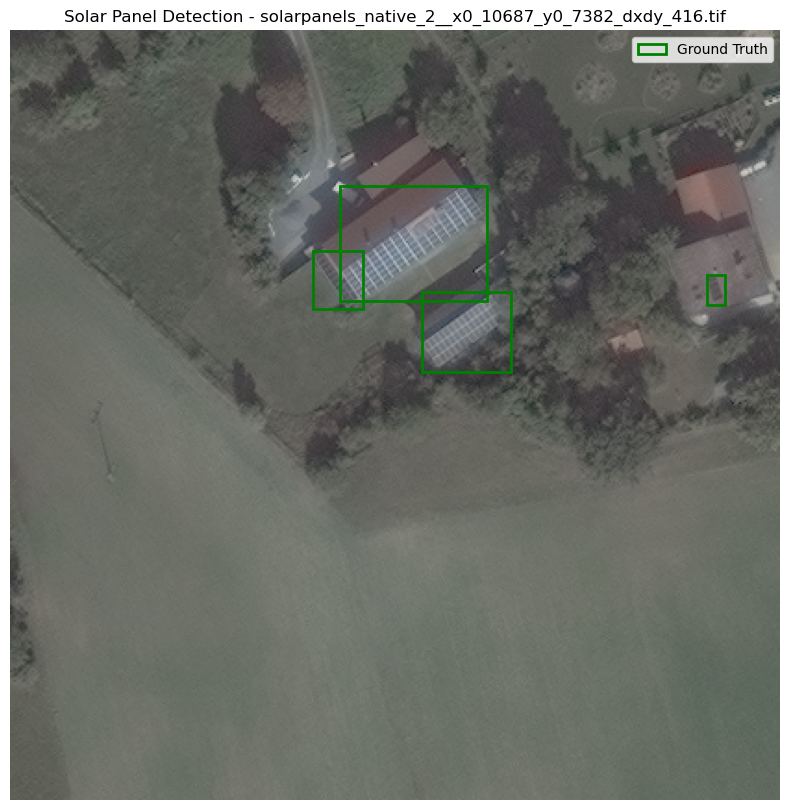

In [24]:
# Visualize random test samples
for i, (img_file, label_file) in enumerate(random_test_samples):
    plt = visualize_detection(img_file, label_file, best_model)
    plt.savefig(os.path.join(base_dir, f'test_sample_{i+1}.png'))
    plt.show()